In [4]:
import torch
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
(train_input, train_target),(test_input, test_target) = keras.datasets.imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input,train_target
)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [6]:
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [7]:
train_dataset = TensorDataset(train_seq,train_target)
val_dataset = TensorDataset(val_seq,val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
class IMDBLstm(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500, 16)
        self.lsml = nn.LSTM(16, 8, num_layers=2, dropout=0.2, batch_first=True)
        self.dense = nn.Linear(8, 1) 
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lsml(x)
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IMDBLstm()
summary(model)
model.to(device)

IMDBLstm(
  (embedding): Embedding(500, 16)
  (lsml): LSTM(16, 8, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [11]:
train_hist = []
val_hist = []
patience = 10
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            optimizer.step()
            val_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f'에포크:{epoch+1}, 훈련손실:{train_loss:.4f}, 검증손실:{val_loss:.4f}')
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'{epoch+1}-실행종료')
            break

에포크:1, 훈련손실:0.6794, 검증손실:0.6931
에포크:2, 훈련손실:0.6952, 검증손실:0.7446
에포크:3, 훈련손실:0.7010, 검증손실:0.7127
에포크:4, 훈련손실:0.6684, 검증손실:0.6908
에포크:5, 훈련손실:0.6364, 검증손실:0.7625
에포크:6, 훈련손실:0.6900, 검증손실:0.6704
에포크:7, 훈련손실:0.6555, 검증손실:0.6910
에포크:8, 훈련손실:0.6777, 검증손실:0.6734
에포크:9, 훈련손실:0.6409, 검증손실:0.7692
에포크:10, 훈련손실:0.7335, 검증손실:0.6946
에포크:11, 훈련손실:0.6937, 검증손실:0.7066
에포크:12, 훈련손실:0.7031, 검증손실:0.6930
에포크:13, 훈련손실:0.6930, 검증손실:0.6970
에포크:14, 훈련손실:0.6947, 검증손실:0.6968
에포크:15, 훈련손실:0.6916, 검증손실:0.6816
에포크:16, 훈련손실:0.6354, 검증손실:0.7311
16-실행종료


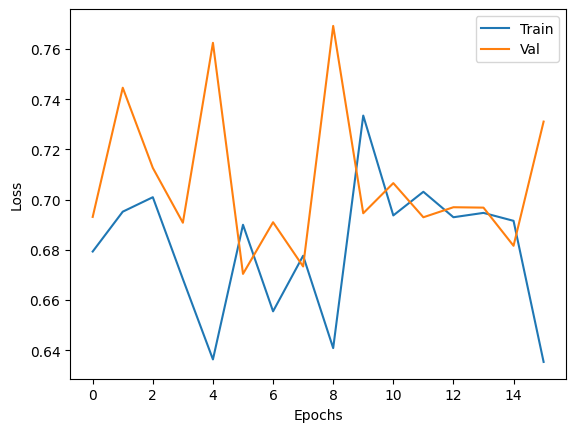

In [12]:
plt.plot(train_hist, label='Train')
plt.plot(val_hist, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load('best_lstm_model.pt',weights_only=True))

<All keys matched successfully>

In [14]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5
        corrects += (predicts == targets).sum().item()
accuracy = corrects / len(val_dataset)

print(f'검증 정확도{accuracy:.4f}')

검증 정확도0.5728
